In [ ]:
!pip install nltk
!pip install spacy
!pip install hvplot
!pip install -U plotly
!pip install -q holoviews
!pip install -U bokeh
!pip install --upgrade bokeh ipykernel

     |████████████████████████████████| 10.7 MB 5.0 MB/s 
  Created wheel for bokeh: filename=bokeh-2.3.3-py3-none-any.whl size=11342786 sha256=b3420f24a2ca9ed57299bae8171c7ac33d3edc4d2e7263aad5a07b3cc02f97bd
  Stored in directory: /root/.cache/pip/wheels/57/e3/79/051e58e8a3d9076de99bdd7d68d463289e28c18329933984ff
Successfully built bokeh
  Attempting uninstall: bokeh
    Found existing installation: bokeh 2.4.1
    Uninstalling bokeh-2.4.1:
      Successfully uninstalled bokeh-2.4.1
  Using cached bokeh-2.4.1-py3-none-any.whl (18.5 MB)
  Attempting uninstall: bokeh
    Found existing installation: bokeh 2.3.3
    Uninstalling bokeh-2.3.3:
      Successfully uninstalled bokeh-2.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
panel 0.12.1 requires bokeh<2.4.0,>=2.3.0, but you have bokeh 2.4.1 which is incompatible.


## Lista 8 - Exercício de Mineração de texto

#### Questão 1 

Use o dataset "tweets_trump.csv", que contém todos os tweets do D. Trump e faça o que é pedido abaixo.

a) Utilizando o texto dos tweets identifique 5 tópicos latentes com o LDA, com um preprocessamento básico -- remoção de urls, remoção de pontuação, stemming e conversão para minúsculo. 

b) Avalie os tópicos encontrados. Algum preprocessamento a mais poderia ser útil para a produção de um melhor resultado?

c) Em seguida, utilize o espaço representado pelas probabilidades de tópicos por documento e identifique o tweet mais similar ao primeiro tweet do dataset. Para isso use a similaridade do cosseno.

In [83]:
import pandas as pd
import pandas as pd
import re
import nltk
import spacy
import string
import numpy as np
import textblob
from textblob import TextBlob
from gensim.matutils import cossim

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
tweets_trump = pd.read_csv('tweets_trump.csv')
tweets_trump.head(5)

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
0,98454970654916608,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02 18:07:48,f
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,f
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17 03:22:47,f
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58,f
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17 13:13:59,f


In [ ]:
tweets_trump.dtypes

id           object
text         object
isRetweet    object
isDeleted    object
device       object
favorites     int64
retweets      int64
date         object
isFlagged    object
dtype: object

In [ ]:
tweets_trump['isRetweet'].unique()

array(['f', 't'], dtype=object)

In [ ]:
tweets_trump['isDeleted'].unique()

array(['f', 't'], dtype=object)

In [ ]:
tweets_trump['isFlagged'].unique()

array(['f', 't'], dtype=object)

In [ ]:
tweets_trump['device'].unique()

array(['TweetDeck', 'Twitter for iPhone', 'Twitter Media Studio',
       'Twitter for Android', 'Twitter Web Client', 'Twitter Web App',
       'Instagram', 'Twitter for iPad', 'Twitter Ads', 'Facebook',
       'Periscope', 'TwitLonger Beta', 'Twitter QandA', 'Twitlonger',
       'Vine - Make a Scene', 'Twitter for BlackBerry',
       'Twitter for Websites', 'Twitter Mirror for iPad',
       'Neatly For BlackBerry 10', 'Media Studio'], dtype=object)

In [ ]:
# Removendo a url da coluna 'text'
tweets_trump['text'] = tweets_trump['text'].str.replace(r'https?://?[^\s<>"]+|www\.[^\s<>"]+', "")

In [ ]:
# Removendo a url da coluna 'text' - aquelas entradas que não se encontravam no padrão definido pela linha anterior, comum as urls
tweets_trump['text'] = tweets_trump['text'].str.replace(r'.*http*', "")

In [ ]:
# Removendo @'s, pois se referem a citações, isso evita erros ao remover a pontuação da frase
# tweets_trump['text'] = tweets_trump['text'].str.replace(r'.*@*', "")

In [ ]:
# Separando apenas a coluna 'text'
tweets_texts = tweets_trump['text']
tweets_texts

0        Republicans and Democrats have both created ou...
1        I was thrilled to be back in the Great city of...
2        RT @CBS_Herridge: READ: Letter to surveillance...
3        The Unsolicited Mail In Ballot Scam is a major...
4        RT @MZHemingway: Very friendly telling of even...
                               ...                        
56566    RT @RandPaul: I don’t know why @JoeBiden think...
56567    RT @EliseStefanik: President @realDonaldTrump ...
56568    RT @TeamTrump: LIVE: Presidential Debate #Deba...
56569    Just signed an order to support the workers of...
56570    Suburban women want Safety &amp; Security. Joe...
Name: text, Length: 56571, dtype: object

In [ ]:
#verficando se ainda existem urls
count = 0
for i in range(len(tweets_texts)):
  sentence_list = tweets_texts[i].split()
  for word in sentence_list:
    if 'http' in word:
      print(word)
      count += 1
print(count)

0


In [ ]:
#verficando se ainda existem @'s
# count_at = 0
# for i in range(len(tweets_texts)):
#   sentence_list = tweets_texts[i].split()
#   for word in sentence_list:
#     if '@' in word:
#       print(word)
#       count_at += 1
# print(count_at)

In [ ]:
#convertendo para minusculo
tweets_prep = tweets_texts.str.lower()
tweets_prep

0        republicans and democrats have both created ou...
1        i was thrilled to be back in the great city of...
2        rt @cbs_herridge: read: letter to surveillance...
3        the unsolicited mail in ballot scam is a major...
4        rt @mzhemingway: very friendly telling of even...
                               ...                        
56566    rt @randpaul: i don’t know why @joebiden think...
56567    rt @elisestefanik: president @realdonaldtrump ...
56568    rt @teamtrump: live: presidential debate #deba...
56569    just signed an order to support the workers of...
56570    suburban women want safety &amp; security. joe...
Name: text, Length: 56571, dtype: object

In [ ]:
PONTUACAO = string.punctuation
PONTUACAO

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
#removendo pontuação
#Alternativa: translator = str.maketrans(dict.fromkeys(string.punctuation))

PONTUACAO = string.punctuation

def remove_pontuacao(text):
    return text.translate(str.maketrans('', '', PONTUACAO))

tweets_prep = tweets_prep.apply(lambda text: remove_pontuacao(text))
tweets_prep

0        republicans and democrats have both created ou...
1        i was thrilled to be back in the great city of...
2        rt cbsherridge read letter to surveillance cou...
3        the unsolicited mail in ballot scam is a major...
4        rt mzhemingway very friendly telling of events...
                               ...                        
56566    rt randpaul i don’t know why joebiden thinks h...
56567    rt elisestefanik president realdonaldtrump exc...
56568    rt teamtrump live presidential debate debates2...
56569    just signed an order to support the workers of...
56570    suburban women want safety amp security joe bi...
Name: text, Length: 56571, dtype: object

In [ ]:
#removendo stopwords

from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

tweets_prep = tweets_prep.apply(lambda text: remove_stopwords(text))
tweets_prep = tweets_prep.apply(lambda text: str(text).strip())
print(tweets_prep)

0          republicans democrats created economic problems
1        thrilled back great city charlotte north carol...
2        rt cbsherridge read letter surveillance court ...
3        unsolicited mail ballot scam major threat demo...
4        rt mzhemingway friendly telling events comeys ...
                               ...                        
56566    rt randpaul don’t know joebiden thinks continu...
56567    rt elisestefanik president realdonaldtrump exc...
56568    rt teamtrump live presidential debate debates2...
56569    signed order support workers delphi corporatio...
56570    suburban women want safety amp security joe bi...
Name: text, Length: 56571, dtype: object


In [ ]:
#aplicando a técnica stemming

from nltk.stem.porter import PorterStemmer


stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

tweets_prep= tweets_prep.apply(lambda text: stem_words(text))
tweets_prep

0                 republican democrat creat econom problem
1        thrill back great citi charlott north carolina...
2        rt cbsherridg read letter surveil court obtain...
3        unsolicit mail ballot scam major threat democr...
4        rt mzhemingway friendli tell event comey appar...
                               ...                        
56566    rt randpaul don’t know joebiden think continu ...
56567    rt elisestefanik presid realdonaldtrump excel ...
56568    rt teamtrump live presidenti debat debates2020...
56569    sign order support worker delphi corpor make s...
56570    suburban women want safeti amp secur joe biden...
Name: text, Length: 56571, dtype: object

In [ ]:
# aplicando o modelo de LDA
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

In [ ]:
dataset_prep = [d.split() for d in tweets_prep]
dictionary_prep = Dictionary(dataset_prep)
corpus_prep = [dictionary_prep.doc2bow(doc) for doc in dataset_prep]

model_prep =LdaModel(corpus=corpus_prep, id2word=dictionary_prep, num_topics=10, iterations=100, passes=5,random_state=1)

In [ ]:
for i in  model_prep.show_topics(num_topics=5, num_words=6, log=False):
    print(i)
    print('---')

(6, '0.051*"thank" + 0.036*"great" + 0.018*"big" + 0.012*"win" + 0.009*"night" + 0.009*"new"')
---
(5, '0.028*"rt" + 0.018*"pay" + 0.012*"point" + 0.011*"disgrac" + 0.008*"safeti" + 0.008*"almost"')
---
(2, '0.036*"great" + 0.031*"trump" + 0.026*"impeach" + 0.015*"southern" + 0.015*"meet" + 0.015*"make"')
---
(9, '0.032*"border" + 0.020*"great" + 0.020*"amp" + 0.018*"wall" + 0.015*"secur" + 0.014*"state"')
---
(7, '0.025*"democrat" + 0.017*"amp" + 0.016*"news" + 0.015*"fake" + 0.014*"year" + 0.013*"republican"')
---


In [ ]:
tweets_prep_df = tweets_prep.to_frame(name="tweets")
tweets_prep_df

,tweets
0,republican democrat creat econom problem
1,thrill back great citi charlott north carolina...
2,rt cbsherridg read letter surveil court obtain...
3,unsolicit mail ballot scam major threat democr...
4,rt mzhemingway friendli tell event comey appar...
...,...
56566,rt randpaul don’t know joebiden think continu ...
56567,rt elisestefanik presid realdonaldtrump excel ...
56568,rt teamtrump live presidenti debat debates2020...
56569,sign order support worker delphi corpor make s...


In [84]:
docsProbabilities = model_prep.get_document_topics(corpus_prep, minimum_probability=0)

docsProbabilities

In [85]:
doc0 = model_prep.get_document_topics(corpus_prep[0], minimum_probability=0)
print(cossim(doc0, doc0))

1.0


In [88]:
sim_0 = cossim(doc0, doc0)
sim_0

1.0

In [90]:
diff_ini = 1
for i in range(1, len(corpus_prep), 1):
  doc = model_prep.get_document_topics(corpus_prep[i], minimum_probability=0)
  sim = cossim(doc0, doc)
  diff = sim_0 - sim
  if diff < diff_ini:
    diff_ini = diff
    row = i
print(f"Linha: {row} tem maior similaridade com a Linha 0, com diferença entre a similaridade igual a {diff_ini}")

Linha: 2675 tem maior similaridade com a Linha 0, com diferença entre a similaridade igual a -4.121536267831516e-08


In [92]:
doc0

[(0, 0.016666962),
 (1, 0.016667034),
 (2, 0.016666666),
 (3, 0.016676795),
 (4, 0.016670274),
 (5, 0.016666666),
 (6, 0.016667541),
 (7, 0.84998477),
 (8, 0.016666666),
 (9, 0.016666675)]

In [93]:
doc = model_prep.get_document_topics(corpus_prep[row], minimum_probability=0)
doc

[(0, 0.016668629),
 (1, 0.016671969),
 (2, 0.016666668),
 (3, 0.016670438),
 (4, 0.016675837),
 (5, 0.016670091),
 (6, 0.016670113),
 (7, 0.84996986),
 (8, 0.016668981),
 (9, 0.016667413)]

In [ ]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    margin:auto;
}
.prompt 
    display:none;
} 
</style>
""")

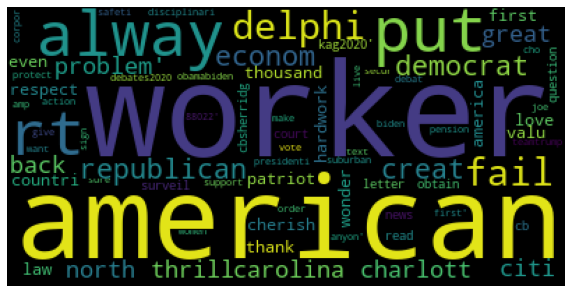

In [ ]:
#Criando uma word cloud após tratamento dos tweets

from wordcloud import WordCloud, ImageColorGenerator

import matplotlib.pyplot as plt

text = tweets_prep_df['tweets'].values 

wordcloud = WordCloud().generate(str(text))
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Questão 2

Use o dataset "tweets_trump.csv" e responda:

a) Qual o sentimento dos 5 tweets com maior número de retweets?

b) Faça uma análise do sentimento geral de todos os tweets. Para isso, visualize a distribuição de polaridade para embasar a sua resposta.

In [ ]:
tweets_trump = pd.read_csv('tweets_trump.csv')
tweets_trump.head(5)

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
0,98454970654916608,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02 18:07:48,f
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,f
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17 03:22:47,f
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58,f
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17 13:13:59,f


In [ ]:
tweets_sorted = tweets_trump.sort_values(by=['retweets'], ascending=False)
tweets_sorted

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
11759,1311892190680014849,"Tonight, @FLOTUS and I tested positive for COV...",f,f,Twitter for iPhone,1869706,408866,2020-10-02 04:54:06,f
35620,881503147168071680,#FraudNewsCNN #FNN https://t.co/WYUnHjjUjg,f,f,Twitter for iPhone,503063,293109,2017-07-02 13:21:42,f
39347,795954831718498305,TODAY WE MAKE AMERICA GREAT AGAIN!,f,f,Twitter for Android,498035,281289,2016-11-08 11:43:14,f
29598,474134260149157888,Are you allowed to impeach a president for gro...,f,f,Twitter for Android,231077,237674,2014-06-04 10:23:11,f
9080,1267637602724839424,RT @SpaceX: Liftoff! https://t.co/DRBfdUM7JA,t,f,Twitter for iPhone,0,235250,2020-06-02 02:02:10,f
...,...,...,...,...,...,...,...,...,...
25181,296278036582629376,@SandyInu We'll see.,f,f,Twitter Web Client,0,0,2013-01-29 15:26:03,f
25537,289481566999158784,@LaDaleBuggs Thank you.,f,f,Twitter Web Client,0,0,2013-01-10 21:19:18,f
25182,296277147373412354,@Cletendre21 @LetendreLarry But not hard enoug...,f,f,Twitter Web Client,0,0,2013-01-29 15:22:31,f
25536,289481811623571456,@MStuart1970 @foxandfriends True!,f,f,Twitter Web Client,0,0,2013-01-10 21:20:16,f


In [ ]:
# Os 5 tweets com maior número de retweets
tweets_top5 = tweets_sorted.iloc[0:5]
tweets_top5

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
11759,1311892190680014849,"Tonight, @FLOTUS and I tested positive for COV...",f,f,Twitter for iPhone,1869706,408866,2020-10-02 04:54:06,f
35620,881503147168071680,#FraudNewsCNN #FNN https://t.co/WYUnHjjUjg,f,f,Twitter for iPhone,503063,293109,2017-07-02 13:21:42,f
39347,795954831718498305,TODAY WE MAKE AMERICA GREAT AGAIN!,f,f,Twitter for Android,498035,281289,2016-11-08 11:43:14,f
29598,474134260149157888,Are you allowed to impeach a president for gro...,f,f,Twitter for Android,231077,237674,2014-06-04 10:23:11,f
9080,1267637602724839424,RT @SpaceX: Liftoff! https://t.co/DRBfdUM7JA,t,f,Twitter for iPhone,0,235250,2020-06-02 02:02:10,f


In [ ]:
def clean_tweet(tweet):
  return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

In [ ]:
def analize_sentiment(tweet):
  analysis = TextBlob(clean_tweet(tweet))
  if analysis.sentiment.polarity > 0:
    return 1
  elif analysis.sentiment.polarity == 0:
    return 0
  else:
    return -1

In [ ]:
tweets_top5['SA'] = np.array([analize_sentiment(tweet) for tweet in tweets_top5['text']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
tweets_top5

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged,SA
11759,1311892190680014849,"Tonight, @FLOTUS and I tested positive for COV...",f,f,Twitter for iPhone,1869706,408866,2020-10-02 04:54:06,f,1
35620,881503147168071680,#FraudNewsCNN #FNN https://t.co/WYUnHjjUjg,f,f,Twitter for iPhone,503063,293109,2017-07-02 13:21:42,f,0
39347,795954831718498305,TODAY WE MAKE AMERICA GREAT AGAIN!,f,f,Twitter for Android,498035,281289,2016-11-08 11:43:14,f,1
29598,474134260149157888,Are you allowed to impeach a president for gro...,f,f,Twitter for Android,231077,237674,2014-06-04 10:23:11,f,0
9080,1267637602724839424,RT @SpaceX: Liftoff! https://t.co/DRBfdUM7JA,t,f,Twitter for iPhone,0,235250,2020-06-02 02:02:10,f,0


In [ ]:
pos_tweets = [tweet for index, tweet in enumerate(tweets_top5['text']) if tweets_top5['SA'].iloc[index] > 0]
neu_tweets = [tweet for index, tweet in enumerate(tweets_top5['text']) if tweets_top5['SA'].iloc[index] == 0]
neg_tweets = [tweet for index, tweet in enumerate(tweets_top5['text']) if tweets_top5['SA'].iloc[index] < 0]
# Printando as porcentagens:
print("Percentage of positive tweets: {}%".format(len(pos_tweets)*100/len(tweets_top5['text'])))
print("Percentage of neutral tweets: {}%".format(len(neu_tweets)*100/len(tweets_top5['text'])))
print("Percentage de negative tweets: {}%".format(len(neg_tweets)*100/len(tweets_top5['text'])))

Percentage of positive tweets: 40.0%
Percentage of neutral tweets: 60.0%
Percentage de negative tweets: 0.0%


In [ ]:
# Análise do sentimento dos 5 tweets com mais retweets
from nltk.sentiment import SentimentIntensityAnalyzer

tweets_top5_text = tweets_top5['text']
total = 0

sent = SentimentIntensityAnalyzer()

def checkPolarity(review):
  score = sent.polarity_scores(review)["compound"]
  return score

for review in tweets_top5_text: 
  score = checkPolarity(review)
  print(f"{review} - Score:{score}")
  print('\n')

  total += score
media = total/ len(tweets_top5_text)

Tonight, @FLOTUS and I tested positive for COVID-19. We will begin our quarantine and recovery process immediately. We will get through this TOGETHER! - Score:0.5983


#FraudNewsCNN #FNN https://t.co/WYUnHjjUjg - Score:0.0


TODAY WE MAKE AMERICA GREAT AGAIN! - Score:0.6588


Are you allowed to impeach a president for gross incompetence? - Score:-0.7506


RT @SpaceX: Liftoff! https://t.co/DRBfdUM7JA - Score:0.0




/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
print(f"Valor médio do sentimento dos top 5 tweets com mais retweet {round(media,3)}")

Valor médio do sentimento dos top 5 tweets com mais retweet 0.101


In [ ]:
#Analisando todos os tweets:

tweets_text = tweets_trump['text']
total = 0
media = 0

sent = SentimentIntensityAnalyzer()

def checkPolarity(review):
  score = sent.polarity_scores(review)["compound"]
  return score

for review in tweets_text: 
  score = checkPolarity(review)
  print(f"{review} - Score:{score}")
  print('\n')

  total += score
media = total/ len(tweets_text)

A saída de streaming foi truncada nas últimas 5000 linhas.


Big announcement today: Drug companies have to come clean about their prices in TV ads. Historic transparency for American patients is here. If drug companies are ashamed of those prices—lower them! - Score:-0.1759


“The reality is, with the Tariffs, the economy has grown more rapidly in the United States and much more slowly in China.” Peter Morici, Former Chief Economist, USITC - Score:0.4215


Getting ready to leave for one of my favorite places, the Florida Panhandle, where we’ve given, and are giving, billions of $$$ for the devastation caused by Hurricane Michael. Even though the Dems are totally in our way (they don’t want money to go there) we’re getting it done! - Score:0.6696


Thank you @NewtGingrich &amp, @FoxandFriends! https://t.co/GYJ7U2k7nn - Score:0.4199


Our Nation grieves at the unspeakable violence that took a precious young life and badly injured others in Colorado. God be with the families and thank yo

In [ ]:
print(f"Valor médio do sentimento dos tweets do dataset 'tweet_trump.csv' {round(media,3)}")

Valor médio do sentimento dos tweets do dataset 'tweet_trump.csv' 0.182


In [ ]:
#Analisando todos os tweets:

tweets_text = tweets_trump['text']
total = 0
media = 0

sent = SentimentIntensityAnalyzer()

def checkPolarity(review):
  return sent.polarity_scores(review)

for review in tweets_text: 
  print(f"{review}\n")
  print(f"Score:{checkPolarity(review)}")
  print('\n------------------------------------------------------------------------------------')

  total += score
media = total/ len(tweets_text)

A saída de streaming foi truncada nas últimas 5000 linhas.

Score:{'neg': 0.0, 'neu': 0.82, 'pos': 0.18, 'compound': 0.5093}

------------------------------------------------------------------------------------
We have a National Emergency at our Southern Border. The Dems refuse to do what they know is necessary - amend our immigration laws. Would immediately solve the problem! Mexico, with the strongest immigration laws in the World, refuses to help with illegal immigration &amp, drugs!

Score:{'neg': 0.208, 'neu': 0.66, 'pos': 0.132, 'compound': -0.6467}

------------------------------------------------------------------------------------
The Republican Party will become the Party of Great HealthCare! ObamaCare is a disaster, far too expensive and deductibility ridiculously high - virtually unusable! Moving forward in Courts and Legislatively!

Score:{'neg': 0.163, 'neu': 0.577, 'pos': 0.26, 'compound': 0.5962}

------------------------------------------------------------------------

In [ ]:
tweets_sentAnalyzer = tweets_trump[['text']].copy()
tweets_sentAnalyzer

,text
0,Republicans and Democrats have both created ou...
1,I was thrilled to be back in the Great city of...
2,RT @CBS_Herridge: READ: Letter to surveillance...
3,The Unsolicited Mail In Ballot Scam is a major...
4,RT @MZHemingway: Very friendly telling of even...
...,...
56566,RT @RandPaul: I don’t know why @JoeBiden think...
56567,RT @EliseStefanik: President @realDonaldTrump ...
56568,RT @TeamTrump: LIVE: Presidential Debate #Deba...
56569,Just signed an order to support the workers of...


In [ ]:
tweets_sentAnalyzer['Negative'] = np.array([checkPolarity(tweet)["neg"] for tweet in tweets_sentAnalyzer['text']])
tweets_sentAnalyzer['Neutral'] = np.array([checkPolarity(tweet)["neu"] for tweet in tweets_sentAnalyzer['text']])
tweets_sentAnalyzer['Positive'] = np.array([checkPolarity(tweet)["pos"] for tweet in tweets_sentAnalyzer['text']])
tweets_sentAnalyzer['Compound'] = np.array([checkPolarity(tweet)["compound"] for tweet in tweets_sentAnalyzer['text']])
tweets_sentAnalyzer

,text,Negative,Neutral,Positive,Compound
0,Republicans and Democrats have both created ou...,0.231,0.598,0.171,-0.1779
1,I was thrilled to be back in the Great city of...,0.000,0.553,0.447,0.9792
2,RT @CBS_Herridge: READ: Letter to surveillance...,0.000,1.000,0.000,0.0000
3,The Unsolicited Mail In Ballot Scam is a major...,0.294,0.706,0.000,-0.9551
4,RT @MZHemingway: Very friendly telling of even...,0.000,0.857,0.143,0.5413
...,...,...,...,...,...
56566,RT @RandPaul: I don’t know why @JoeBiden think...,0.130,0.870,0.000,-0.5574
56567,RT @EliseStefanik: President @realDonaldTrump ...,0.000,0.837,0.163,0.5423
56568,RT @TeamTrump: LIVE: Presidential Debate #Deba...,0.000,1.000,0.000,0.0000
56569,Just signed an order to support the workers of...,0.176,0.670,0.154,-0.4678


In [ ]:
# import numpy as np
# import pandas as pd
# import hvplot.pandas
# import os
# import holoviews as hv

# os.environ['HV_DOC_HTML'] = 'true'
# hv.extension('bokeh') 
# hv.config.enable_colab_support = True

# tweets_sentAnalyzer.hvplot(x='Compound', y=['Negative', 'Neutral', 'Positive'], kind='scatter')

In [ ]:
import plotly.express as px

fig = px.scatter(data_frame=tweets_sentAnalyzer, x='Compound', y=['Negative', 'Neutral', 'Positive'])
fig.show()